In [1]:
from typing import Tuple

import cv2
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:

def train_grabcut(img, rect) -> Tuple[np.ndarray, np.ndarray]:
    mask = np.zeros(img.shape[:2], np.uint8)
    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)
    rect = (0,50,320,240-50)
    _, bgdModel, fgdModel = cv2.grabCut(img, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)
    return bgdModel, fgdModel, mask

def eval_grabcut(img, mask, bgdModel, fgdModel) -> np.ndarray:
    mask, _, _= cv2.grabCut(img, mask, None, bgdModel, fgdModel, 1, cv2.GC_EVAL_FREEZE_MODEL)
    mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
    return mask2[:,:,np.newaxis]

def compare_grabcut(img, masked) -> np.ndarray:
    plt.figure(figsize=(20,10))
    plt.subplot(121)
    plt.imshow(cv2.cvtColor(img*masked, cv2.COLOR_BGR2RGB))
    plt.subplot(122)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [3]:
class GrabCutModel:
    def __init__(self, urban_im, urban_box, rual_im, rual_box) -> None:
        self.bgdUrban, self.fgdUrban, self.maskUrban = train_grabcut(urban_im, urban_box)
        self.bgdRural, self.fgdRural, self.maskRural = train_grabcut(rual_im, rual_box)
        
    def eval_image(self, img: np.ndarray) -> np.ndarray:
        urbanMask = eval_grabcut(img, self.maskUrban, self.bgdUrban, self.fgdUrban)
        ruralMask = eval_grabcut(img, self.maskRural, self.bgdRural, self.fgdRural)
        return urbanMask | ruralMask

Reading data/000100-0.00.jpg


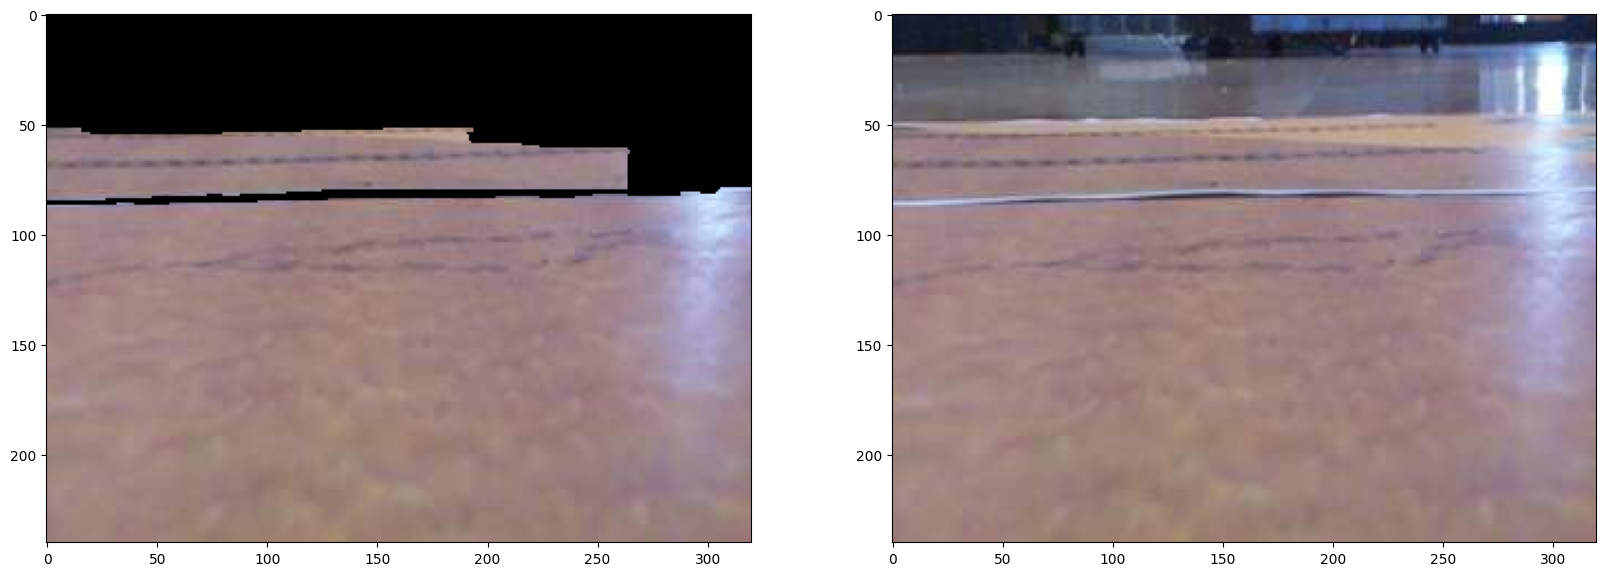

In [4]:
filename = sorted(list(Path("./data").glob("./*.jpg")))[100]
print(f"Reading {filename}")
rural_img = cv2.imread(str(filename))
rural_rect = (0,50,320,240-50)
bgdModel, fgdModel, mask = train_grabcut(rural_img, rural_rect)
masked = eval_grabcut(rural_img, mask, bgdModel, fgdModel)
compare_grabcut(rural_img, masked)

Reading data/000300-0.30.jpg


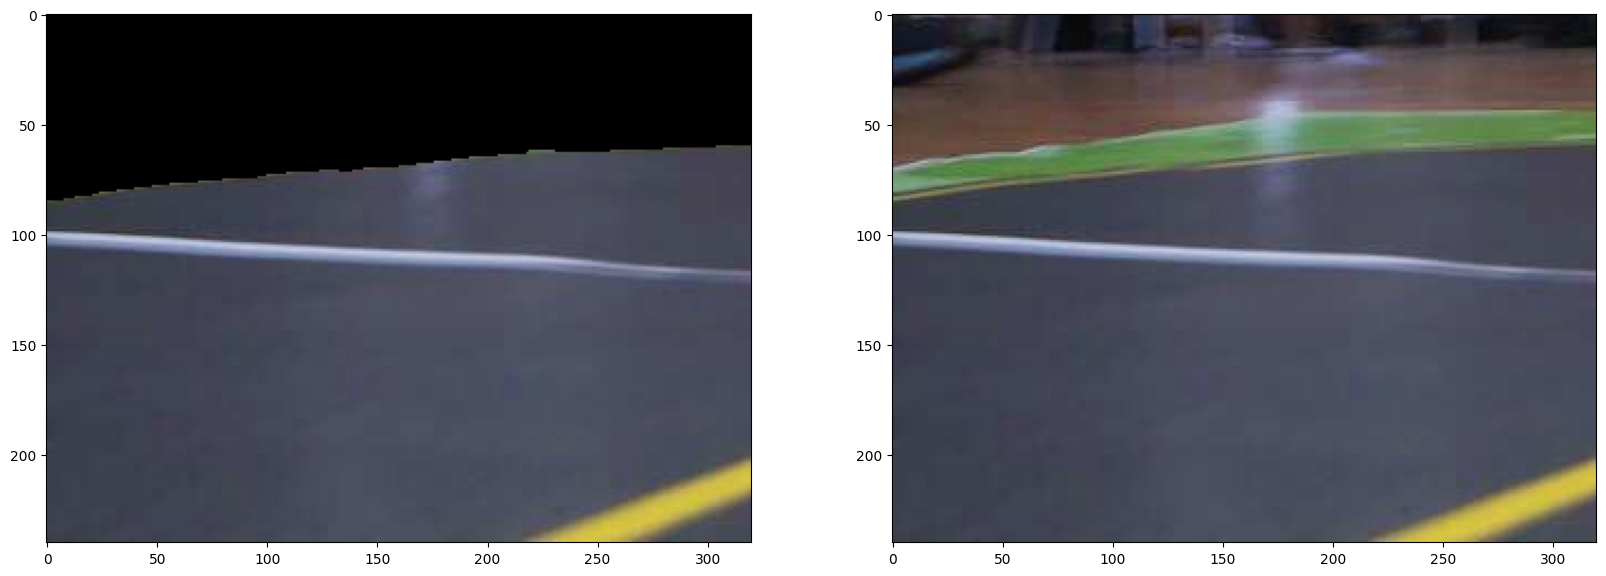

In [5]:
filename = sorted(list(Path("./data").glob("./*.jpg")))[300]
print(f"Reading {filename}")
urban_img = cv2.imread(str(filename))
urban_rect = (0,50,320,240-50)
bgdModel, fgdModel, mask = train_grabcut(urban_img, urban_rect)
masked = eval_grabcut(urban_img, mask, bgdModel, fgdModel)
compare_grabcut(urban_img, masked)

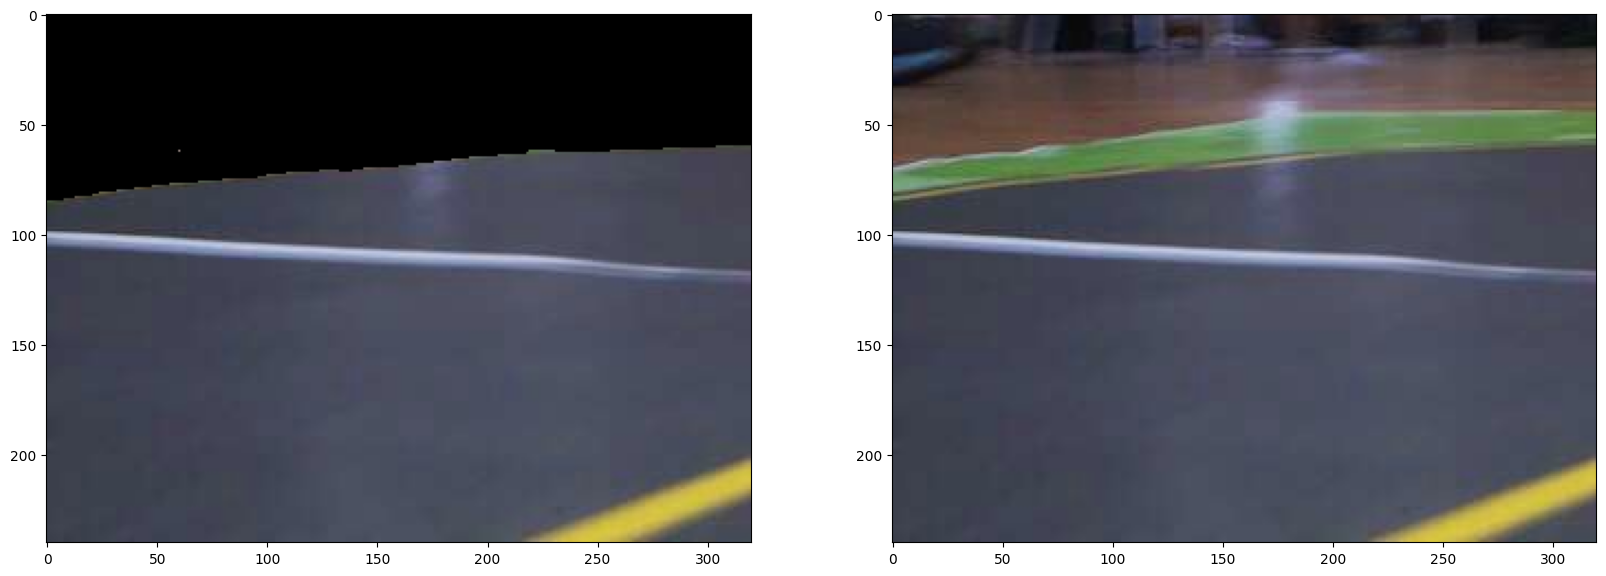

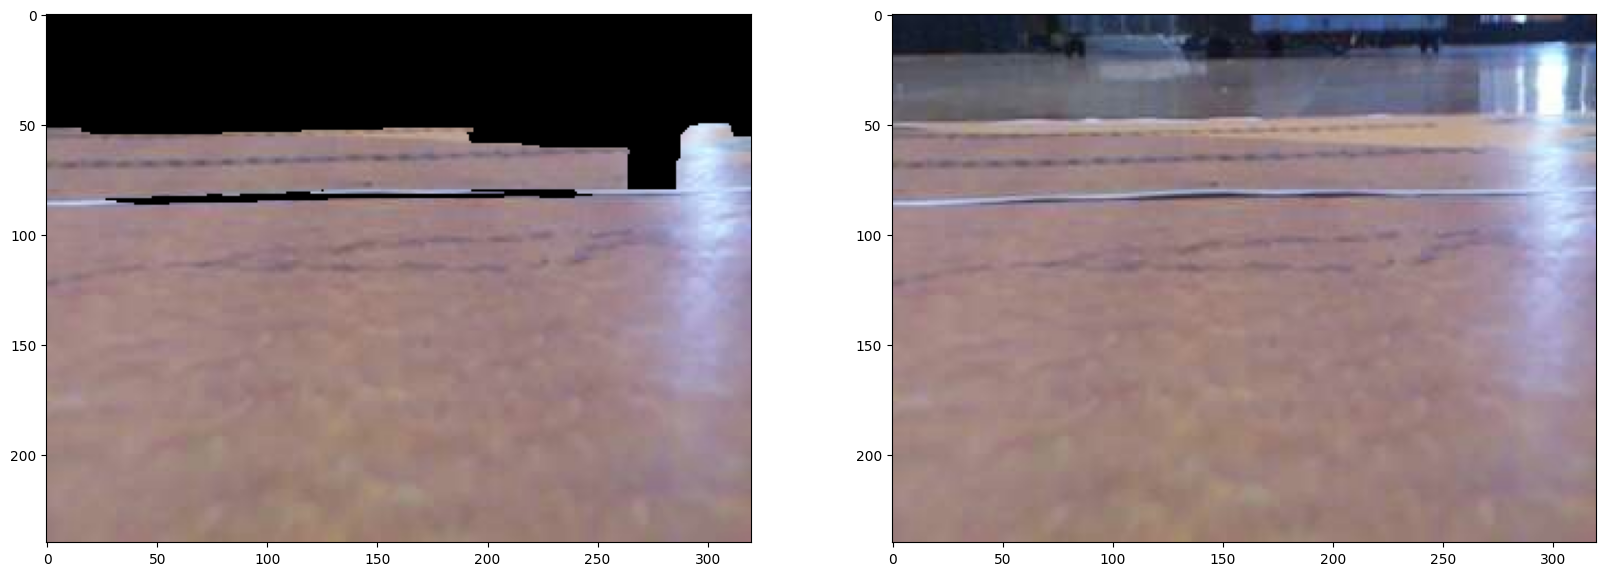

In [6]:
model = GrabCutModel(urban_img, urban_rect, rural_img, rural_rect)
masked = model.eval_image(urban_img)
compare_grabcut(urban_img, masked)
masked = model.eval_image(rural_img)
compare_grabcut(rural_img, masked)

In [ ]:
# filename = sorted(list(Path("./data").glob("./*.jpg")))[130]
# print(f"Reading {filename}")
# img2 = cv2.imread(str(filename))
# masked = model.eval_image(img2)
# compare_grabcut(img2, masked)

In [13]:
from tqdm.auto import tqdm

fourcc = cv2.VideoWriter_fourcc(*'MJPG')
writer = cv2.VideoWriter("grabcut.avi", fourcc, 10.0, (320, 240))

for file_ in tqdm(sorted(list(Path("./data").glob("./*.jpg")))):
    img = cv2.imread(str(file_))
    masked = model.eval_image(img)
    writer.write(img * masked)
    # compare_grabcut(img, masked)
    # plt.show()
writer.release()

  0%|          | 0/913 [00:00<?, ?it/s]

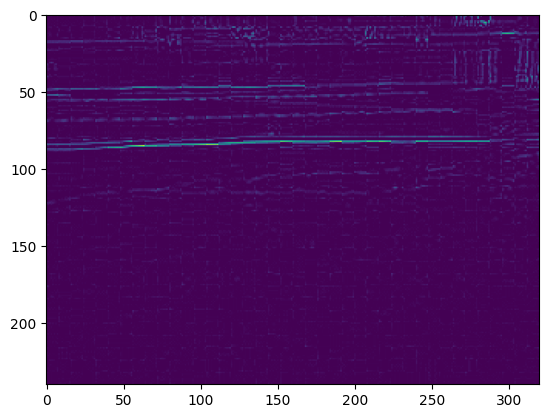

In [29]:
grey = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
# dy = cv2.Sobel(grey, cv2.CV_8U, 0, 1)
# dx = cv2.Sobel(grey, cv2.CV_8U, 1, 0)
grad=cv2.Laplacian(grey, cv2.CV_8U)
plt.imshow(grad)

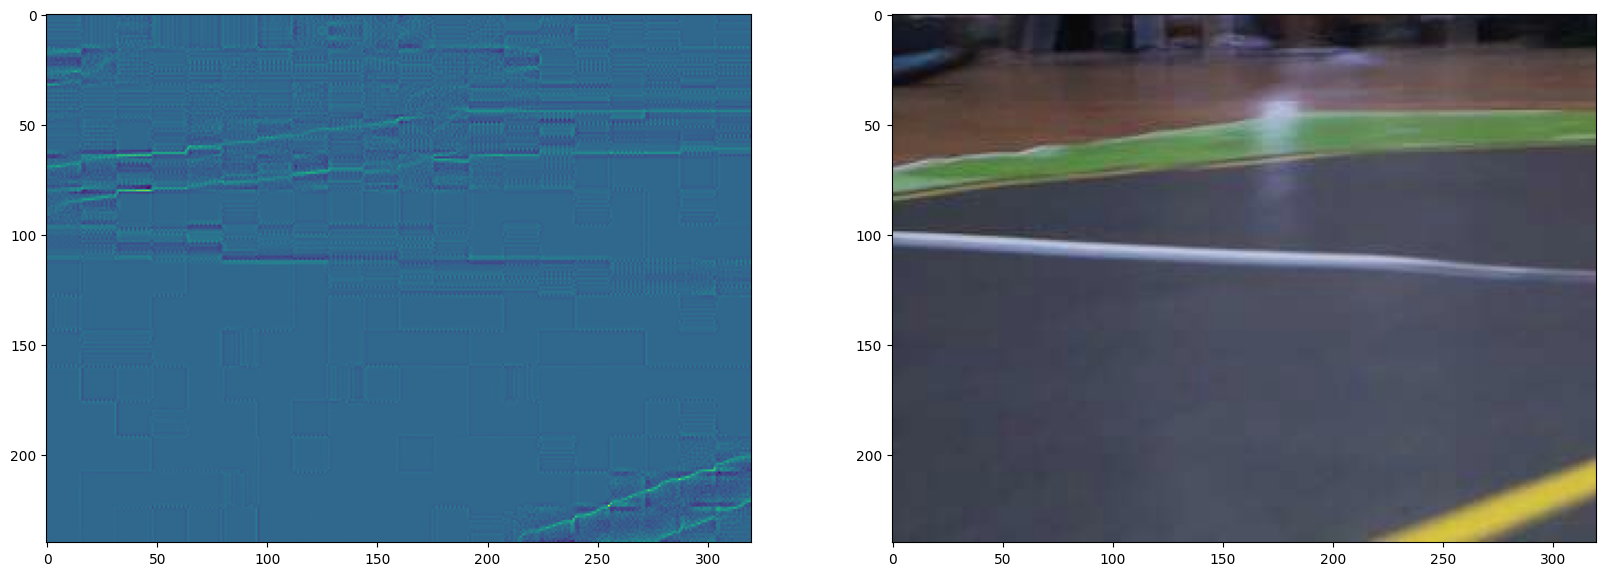

In [61]:
mask = np.ones(img.shape[:-1], dtype=bool)
hsv_im = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# define range of blue color in HSV
lower_blue = np.array([0,0,50])
upper_blue = np.array([255,10,255])
# Threshold the HSV image to get only blue colors
mask = cv2.inRange(hsv_im, lower_blue, upper_blue)
hsv_im = hsv_im.astype(np.float32)
grad=cv2.Laplacian(hsv_im[..., 1] * hsv_im[..., 2], cv2.CV_32F)

plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(grad)
plt.subplot(122)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

[72 75 92]
[116.  55.  92.]


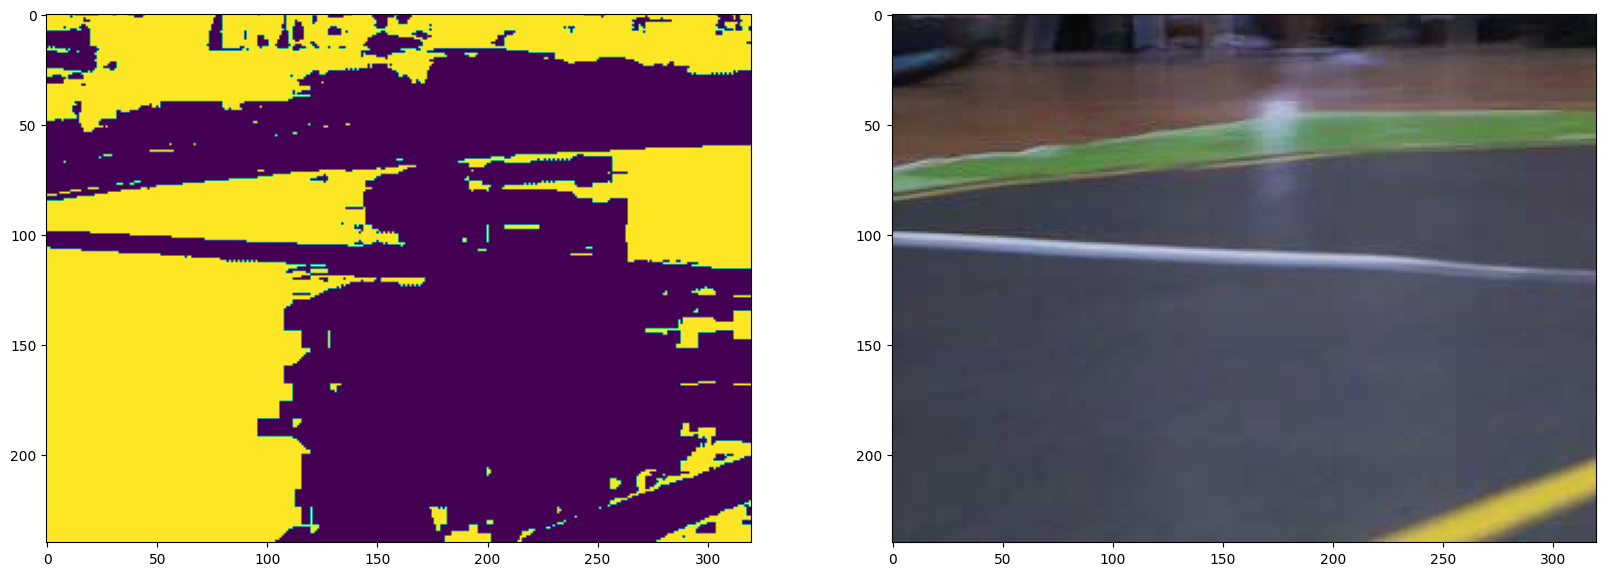

In [70]:
mask = np.ones(img.shape[:-1], dtype=bool)
hsv_im = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# define range of blue color in HSV
lower_blue = np.array([0,0,0])
upper_blue = np.array([255,100,90])
# Threshold the HSV image to get only blue colors
mask = cv2.inRange(hsv_im, lower_blue, upper_blue)
hsv_im = hsv_im.astype(np.float32)
grad=cv2.Laplacian(hsv_im[..., 1] * hsv_im[..., 2], cv2.CV_32F)

plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(mask)
plt.subplot(122)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
print(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)[128,128])
print(hsv_im[128,128])